# Retinal Vessel Segmentation
## Marcelina Gancewska (156024)
### All required imports

In [1]:
# All required imports

# Core Python Libraries
import os
import io

# Numerical operations
import numpy as np
import scipy as sp

# Image Processing 
import cv2
import skimage
from skimage.filters import frangi

# Visualization
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.metrics import ConfusionMatrixDisplay

# Machine Learning Metrics
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

# Medical image processing
from skimage.morphology import remove_small_objects, remove_small_holes, binary_closing, disk
# Image meta parameters
save = True
savePath = "./image_processing"
inputImage = './input/01.jpg'

Image preprocessing

In [2]:
img = cv2.imread(inputImage) # read image
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # to rgb

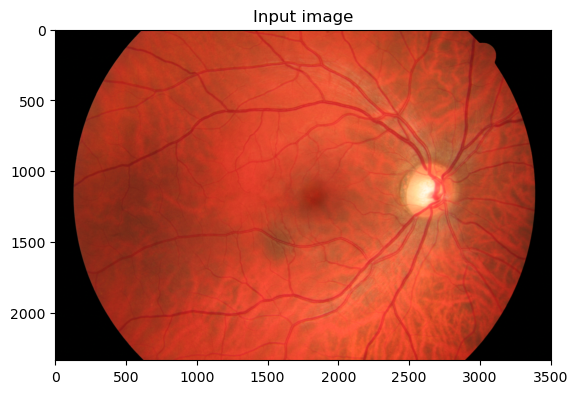

In [3]:
plt.title('Input image')
plt.imshow(img)
if save:
    plt.savefig(f'{savePath}/inputImage.png')

Visualize input image via color channels

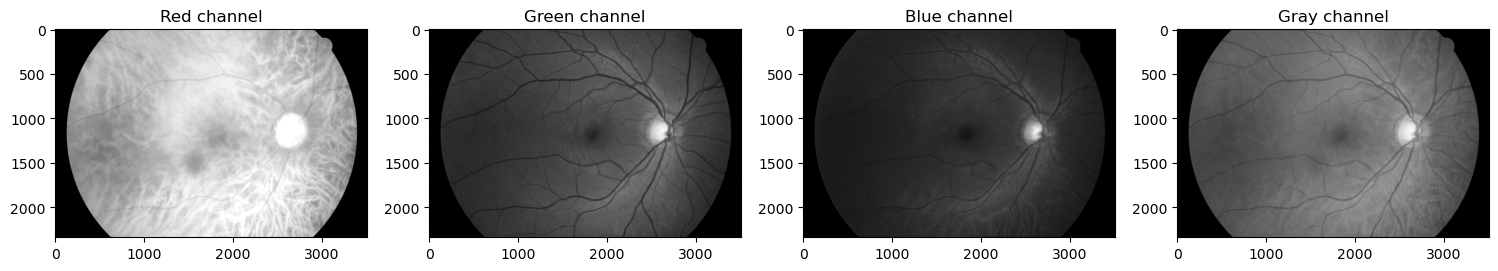

In [4]:
fig, ax = plt.subplots(1, 4)
fig.set_size_inches(18.5, 10.5)

ax[0].set_title('Red channel')
ax[0].imshow(img[:, :, 0], cmap='gray')

ax[1].set_title('Green channel')
ax[1].imshow(img[:, :, 1], cmap='gray')

ax[2].set_title('Blue channel')
ax[2].imshow(img[:, :, 2], cmap='gray')

ax[3].set_title('Gray channel')
ax[3].imshow(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), cmap='gray')

if save:
    plt.savefig(f'{savePath}/channels.png')

Additional image processing : frangi filter, color historgam normization and?

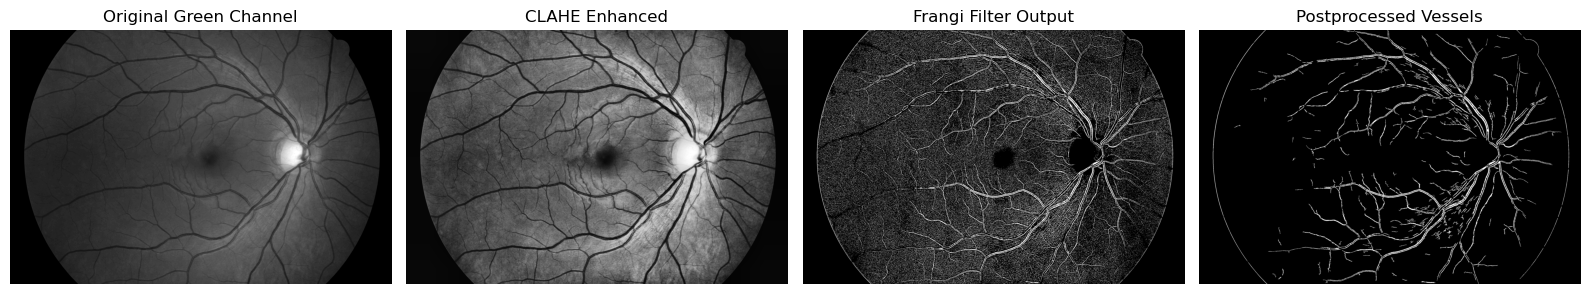

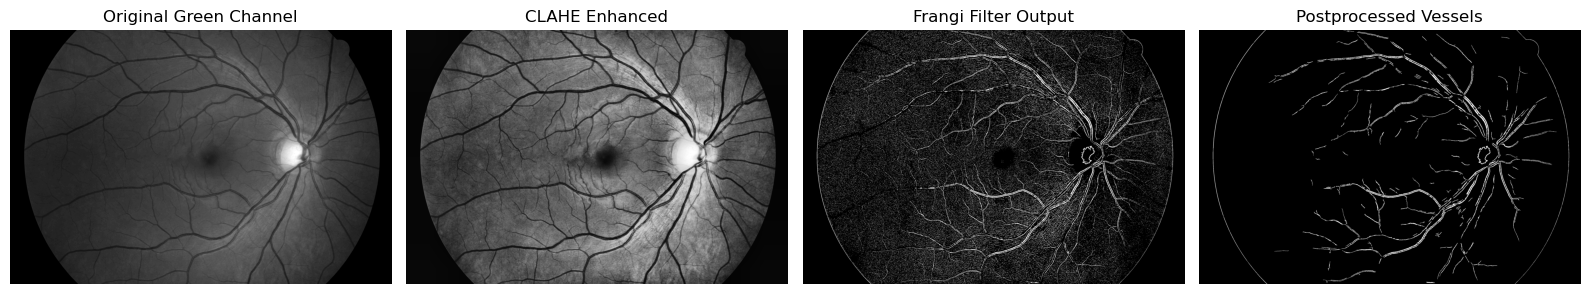

In [15]:
def preprocess_image(image):
    # Take green channel from the image
    green_channel = image[:, :, 1]
    # Removes overly dark (≤10) and overly bright (≥245) pixels to reduce noise and improve contrast
    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clipped = np.clip(green_channel, 10, 245)
    clahe_processor = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8, 8)) 
    enhanced = clahe_processor.apply(clipped)
    return clipped, enhanced

def apply_frangi_filter(image, threshold=0.02, sigma_start=1, sigma_end=5, sigma_step=0.5):
    # Apply Frangi filter
    filtered = frangi(
        image, 
        sigmas=np.arange(sigma_start, sigma_end, sigma_step),
        black_ridges=True,  # Change to False if your ridges are brighter than background
        scale_range=None,
        scale_step=None,
        alpha=0.5,  # Frangi correction constant
        beta=0.5,   # Frangi correction constant
        gamma=15    # Frangi correction constant (adjusts sensitivity)
    )
    
    # Normalize using min max [0,1]
    normalized = (filtered - np.min(filtered)) / (np.max(filtered) - np.min(filtered))
    
    # Thresholding 0 or 1
    binary_output = (normalized > threshold).astype(np.uint8) * 255
    
    return binary_output

def plot_results(original, enhanced, filtered, processed, output_path=None):
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    
    titles = ['Original Green Channel', 'CLAHE Enhanced', 
              'Frangi Filter Output', 'Postprocessed Vessels']
    images = [original, enhanced, filtered, processed]
    
    for ax, img, title in zip(axs, images, titles):
        ax.imshow(img, cmap='gray')
        ax.set_title(title)
        ax.axis('off')
    
    plt.tight_layout()
    
    if output_path:
        fig.savefig(f'{output_path}/vessel_detection_pipeline.png')


def postprocess_vessels(binary_image, min_size=150, closing_radius=2):
    # Remove tiny isolated pixels
    cleaned = remove_small_objects(binary_image.astype(bool), min_size=min_size)

    # Fill small holes inside vessels
    filled = remove_small_holes(cleaned, area_threshold=min_size)

    return filled.astype(np.uint8)

# --- Main execution ---

result_list = []

gray_img, clahe_img = preprocess_image(img)
frangi_mask = apply_frangi_filter(clahe_img)
post_processed_mask = postprocess_vessels(frangi_mask)

plot_results(gray_img, clahe_img, frangi_mask, post_processed_mask,output_path=savePath if save else None)

result_list.append(frangi_mask)
def suppress_background(image, low_thresh=15, high_thresh=245):
    """Suppress background pixels by zeroing out too dark or too bright regions."""
    suppressed = np.copy(image)
    mask = (suppressed > low_thresh) & (suppressed < high_thresh)
    suppressed[~mask] = 0
    return suppressed
gray_img, clahe_img = preprocess_image(img)

# Suppress background on the CLAHE image
background_suppressed = suppress_background(clahe_img)

# Apply Frangi to background-suppressed image
frangi_mask = apply_frangi_filter(background_suppressed)

post_processed_mask = postprocess_vessels(frangi_mask)

plot_results(gray_img, clahe_img, frangi_mask, post_processed_mask, output_path=savePath if save else None)






Performance Metrics:

Confusion Matrix:
True Positives: 339079
False Positives: 1006593
True Negatives: 6344863
False Negatives: 494809
Accuracy: 0.8166
Sensitivity (Recall): 0.4066
Specificity: 0.8631
Arithmetic Mean (Sensitivity+Specificity)/2: 0.6348
Geometric Mean sqrt(Sensitivity*Specificity): 0.5924


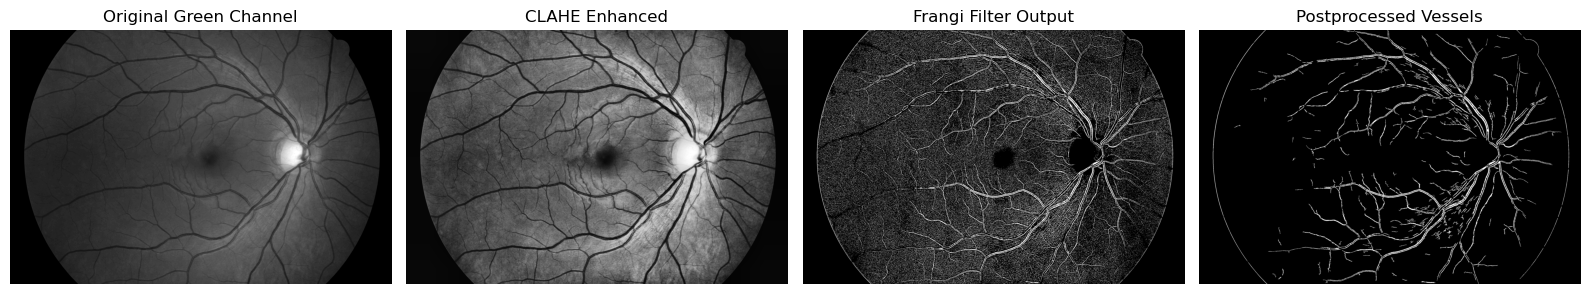

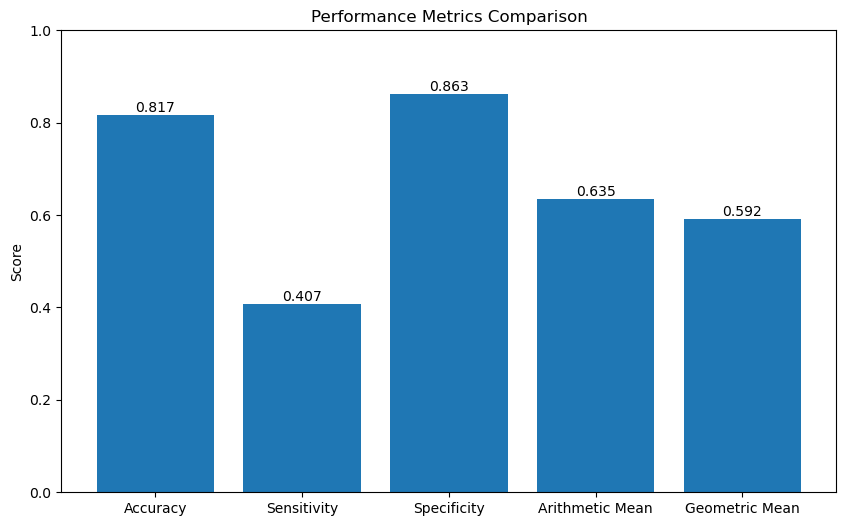

In [9]:
def evaluate_performance(predicted_mask, ground_truth_mask):
    """
    Calculate performance metrics for vessel segmentation.
    """
    # Convert masks to boolean (0=False=background, 1=True=vessel)
    pred = predicted_mask == 255
    gt = ground_truth_mask == 255
    
    # Calculate confusion matrix components
    tp = np.sum(pred & gt)  # True positives
    fp = np.sum(pred & ~gt)  # False positives
    tn = np.sum(~pred & ~gt)  # True negatives
    fn = np.sum(~pred & gt)  # False negatives
    
    # Calculate metrics
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    sensitivity = tp / (tp + fn)  # Recall or true positive rate
    specificity = tn / (tn + fp)  # True negative rate
    
    # Balanced metrics
    arithmetic_mean = (sensitivity + specificity) / 2
    geometric_mean = np.sqrt(sensitivity * specificity)
    
    # Create confusion matrix in dictionary form
    confusion_matrix = {
        'True Positives': tp,
        'False Positives': fp,
        'True Negatives': tn,
        'False Negatives': fn
    }
    
    metrics = {
        'Confusion Matrix': confusion_matrix,
        'Accuracy': accuracy,
        'Sensitivity (Recall)': sensitivity,
        'Specificity': specificity,
        'Arithmetic Mean (Sensitivity+Specificity)/2': arithmetic_mean,
        'Geometric Mean sqrt(Sensitivity*Specificity)': geometric_mean
    }
    
    return metrics

def plot_metrics_comparison(metrics_dict, output_path=None):
    """Plot the metrics for visual comparison."""
    metrics_to_plot = {
        'Accuracy': metrics_dict['Accuracy'],
        'Sensitivity': metrics_dict['Sensitivity (Recall)'],
        'Specificity': metrics_dict['Specificity'],
        'Arithmetic Mean': metrics_dict['Arithmetic Mean (Sensitivity+Specificity)/2'],
        'Geometric Mean': metrics_dict['Geometric Mean sqrt(Sensitivity*Specificity)']
    }
    
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(metrics_to_plot.keys(), metrics_to_plot.values())
    ax.set_ylim(0, 1)
    ax.set_title('Performance Metrics Comparison')
    ax.set_ylabel('Score')
    
    # Add values on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')
    
    if output_path:
        fig.savefig(f'{output_path}/performance_metrics.png')


result_list = []

gray_img, clahe_img = preprocess_image(img)
frangi_mask = apply_frangi_filter(clahe_img)
post_processed_mask = postprocess_vessels(frangi_mask)

# Evaluate performance (you need to provide ground_truth_mask)
ground_truth_mask = cv2.imread('./groundTruth/01.png', cv2.IMREAD_GRAYSCALE)
metrics = evaluate_performance(frangi_mask, ground_truth_mask)

# Print metrics
print("\nPerformance Metrics:")
for key, value in metrics.items():
    if key == 'Confusion Matrix':
        print("\nConfusion Matrix:")
        for k, v in value.items():
            print(f"{k}: {v}")
    else:
        print(f"{key}: {value:.4f}")

# Plot results including metrics
plot_results(gray_img, clahe_img, frangi_mask, post_processed_mask, output_path=savePath if save else None)
plot_metrics_comparison(metrics, output_path=savePath if save else None)

result_list.append(frangi_mask)

In [8]:
input_files = ['01.jpg', '02.jpg', '03.jpg', '04.jpg', '05.jpg']
ground_truth_files = ['01.png', '02.png', '03.png', '04.png', '05.png']
results = []

for i in range(len(input_files)):
    # Load and process image
    img = cv2.imread(f'./input/{input_files[i]}')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray_img, clahe_img = preprocess_image(img)
    frangi_mask = apply_frangi_filter(clahe_img)
    ground_truth_mask = cv2.imread(f'./groundTruth/{ground_truth_files[i]}', cv2.IMREAD_GRAYSCALE)
    
    # Evaluate performance
    metrics = evaluate_performance(frangi_mask, ground_truth_mask)
    results.append(metrics)
    
    # Print individual results
    print(f"\nResults for {input_files[i]}:")
    print(metrics)

# Calculate average metrics
if results:
    avg_metrics = {
        'Accuracy': np.nanmean([m['Accuracy'] for m in results]),
        'Sensitivity': np.nanmean([m['Sensitivity (Recall)'] for m in results]),
        'Specificity': np.nanmean([m['Specificity'] for m in results]),
        'Arithmetic_Mean': np.nanmean([m['Arithmetic Mean (Sensitivity+Specificity)/2'] for m in results]),
        'Geometric_Mean': np.nanmean([m['Geometric Mean sqrt(Sensitivity*Specificity)'] for m in results])
    }

    # Print average results
    print("\n=== AVERAGE RESULTS ACROSS ALL IMAGES ===")
    print(f"Accuracy: {avg_metrics['Accuracy']:.4f}")
    print(f"Sensitivity: {avg_metrics['Sensitivity']:.4f}")
    print(f"Specificity: {avg_metrics['Specificity']:.4f}")
    print(f"Arithmetic Mean: {avg_metrics['Arithmetic_Mean']:.4f}")
    print(f"Geometric Mean: {avg_metrics['Geometric_Mean']:.4f}")


# After calculating avg_metrics 

def plot_average_results(avg_metrics):
    # Create single subplot for metrics
    fig, ax1 = plt.subplots(figsize=(8, 6))
    
    # Plot metrics
    metrics_to_plot = {
        'Accuracy': avg_metrics['Accuracy'],
        'Sensitivity': avg_metrics['Sensitivity'],
        'Specificity': avg_metrics['Specificity'],
        'Arithmetic Mean': avg_metrics['Arithmetic_Mean'],
        'Geometric Mean': avg_metrics['Geometric_Mean']
    }
    
    bars = ax1.bar(metrics_to_plot.keys(), metrics_to_plot.values())
    ax1.set_ylim(0, 1)
    ax1.set_title('Average Performance Metrics', pad=20)
    ax1.set_ylabel('Score')
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add values on bars
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.4f}',
                 ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Call the plotting function after calculating averages
plot_average_results(avg_metrics)


KeyboardInterrupt: 

In [ ]:
import numpy as np
from skimage import io, feature, transform
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from skimage.feature import graycomatrix, graycoprops
import matplotlib.pyplot as plt

def extract_patch_features(image, patch_size=5):
    """Extract features from image patches"""
    features = []
    half_size = patch_size // 2
    padded = np.pad(image, half_size, mode='reflect')
    
    for y in range(half_size, padded.shape[0]-half_size):
        for x in range(half_size, padded.shape[1]-half_size):
            patch = padded[y-half_size:y+half_size+1, x-half_size:x+half_size+1]
            
            # Basic statistics
            mean = np.mean(patch)
            std = np.std(patch)
            
            # Texture features
            glcm = graycomatrix((patch*255).astype(np.uint8), 
                              distances=[1], 
                              angles=[0],
                              levels=256,
                              symmetric=True,
                              normed=True)
            contrast = graycoprops(glcm, 'contrast')[0,0]
            correlation = graycoprops(glcm, 'correlation')[0,0]
            
            # Hu moments
            moments = feature.moments_central(patch)
            hu_moments = feature.moments_hu(moments)
            
            features.append([
                mean, std, contrast, correlation, *hu_moments
            ])
    
    return np.array(features)

def create_dataset(image_path, mask_path, max_samples=10000):
    """Create balanced training dataset"""
    image = io.imread(image_path, as_gray=True)
    mask = io.imread(mask_path, as_gray=True) > 0.5
    
    # Extract features
    features = extract_patch_features(image)
    
    # Get center pixel labels
    labels = mask.flatten()
    
    # Balance classes
    vessel_idx = np.where(labels == 1)[0]
    background_idx = np.where(labels == 0)[0]
    
    # Undersample majority class
    n_samples = min(len(vessel_idx), len(background_idx), max_samples//2)
    selected_idx = np.concatenate([
        np.random.choice(vessel_idx, n_samples, replace=False),
        np.random.choice(background_idx, n_samples, replace=False)
    ])
    
    return features[selected_idx], labels[selected_idx]

def train_classifier(X_train, y_train):
    """Train random forest classifier"""
    clf = RandomForestClassifier(n_estimators=100,
                                max_depth=10,
                                class_weight='balanced',
                                n_jobs=-1)
    clf.fit(X_train, y_train)
    return clf

def apply_classifier(image, classifier, patch_size=5):
    """Apply trained classifier to new image"""
    half_size = patch_size // 2
    padded = np.pad(image, half_size, mode='reflect')
    output = np.zeros(image.shape)
    
    features = extract_patch_features(image, patch_size)
    preds = classifier.predict_proba(features)[:,1]
    
    return preds.reshape(image.shape)

# Example usage
train_image = "./image_processing/frangi.png"
train_mask = "./groundTruth/01.png"
test_image = "./image_processing/02.png"

# Create and train classifier
X, y = create_dataset(train_image, train_mask)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
clf = train_classifier(X_train, y_train)

# Evaluate
print("Classification Report:")
print(classification_report(y_test, clf.predict(X_test)))

# Apply to test image
test_img = io.imread(test_image, as_gray=True)
result = apply_classifier(test_img, clf)

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
ax1.imshow(test_img, cmap='gray')
ax1.set_title('Original Image')
ax2.imshow(result, cmap='hot')
ax2.set_title('Vessel Probability Map')
plt.show()

AttributeError: No skimage.feature attribute moments_central